In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from math import ceil
from scipy import stats

## Question 1  Evaluate Current Inventory Management Practices

### 1.1 Data Preprocessing
We imported, cleaned, and merged all datasets (Invoices, Locations, Tanks, Fuel_Level_Part_1, Fuel_Level_Part_2)

In [4]:
Invoices=pd.read_csv('Invoices-1.csv').rename(columns={'Invoice Gas Station Location': 'Station_Location','Fuel Type':'Type'}).dropna(how ='any')
Locations=pd.read_csv('Locations-1.csv').rename(columns={'Gas Station Location': 'Station_Location'}).dropna(how ='any')
Tanks=pd.read_csv('Tanks-1.csv').rename(columns={'Tank Location': 'Station_Location','Tank Type':'Type'}).dropna(how ='any')
Fuel1=pd.read_csv('Fuel_Level_Part_1-1.csv') .dropna(how ='any')
Fuel2=pd.read_csv('Fuel_Level_Part_2-1.csv') .dropna(how ='any')# read all the data sets we need, drop missing values
Fuel1=Fuel1.rename(columns={'Fuel Level': 'Fuel_Level','Time stamp': 'Time_Stamp'}) # make sure the name contains no spaces and is the same as the one in Fuel2
Fuel2=Fuel2.rename(columns={'Timestamp': 'Time_Stamp'})
Gas_Type = {'Type': {'U':'G','P':'G'}}
Tanks.replace(Gas_Type,inplace=True)
Fuel_all = pd.concat([Fuel1, Fuel2])# merge Fuel1 & Fuel2
Tanks_Invoices=Tanks.merge(Invoices,on=['Station_Location','Type'],how='outer')
Tanks_Invoices_Locations=Tanks_Invoices.merge(Locations,on=['Station_Location'],how='outer').set_index(['Station_Location','Type'])
Tanks_Invoices_Locations.head(5)# merge Tanks & Locations & Invoices

Tank ID  Tank Number  Tank Capacity Invoice Date  \
Station_Location Type                                                    
1                D       T 12            3          40000     1/2/2017   
                 D       T 12            3          40000     1/3/2017   
                 D       T 12            3          40000     1/4/2017   
                 D       T 12            3          40000     1/5/2017   
                 D       T 12            3          40000     1/6/2017   

                       Invoice ID  Gross Purchase Cost  Amount Purchased  \
Station_Location Type                                                      
1                D        10001.0          12491.85300          9338.736   
                 D        10006.0           5670.54418          4239.216   
                 D        10013.0           7570.82000          5659.840   
                 D        10017.0           9463.52500          7074.800   
                 D        10020.0           9463.52500          7074.800   

                      Gas Station Name  \
Station_Location Type                    
1                D           EastMount   
                 D           EastMount   
                 D           EastMount   
                 D           EastMount   
                 D           EastMount   

                                                    Gas Station Address  \
Station_Location Type                                                     
1                D     386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada   
                 D     386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada   
                 D     386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada   
                 D     386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada   
                 D     386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada   

                       Gas Station Latitude  Gas Station Longitude  
Station_Location Type                                               
1                D                 43.23467              -79.83651  
                 D                 43.23467              -79.83651  
                 D                 43.23467              -79.83651  
                 D                 43.23467              -79.83651  
                 D                 43.23467              -79.83651

### 1.2 Visualize Fuel Levels
We visualized the fuel levels over time for each tank to assess inventory trends.

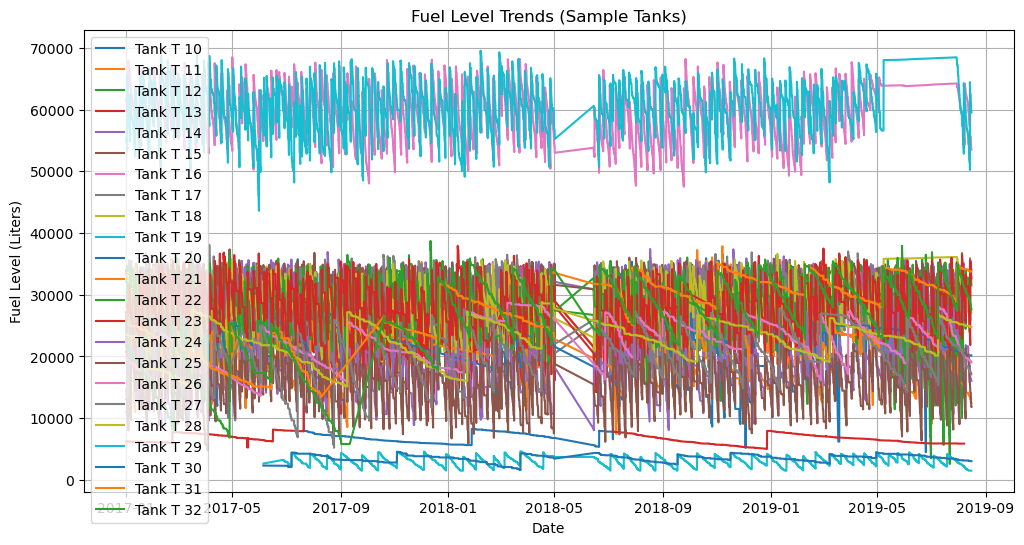

/var/folders/jx/9_tlttmd2w7b3rzppx7v1q5c0000gn/T/ipykernel_11055/2118755871.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stockout.head(10), x='Tank ID', y='Stockout_Risk_Count', palette='pastel')


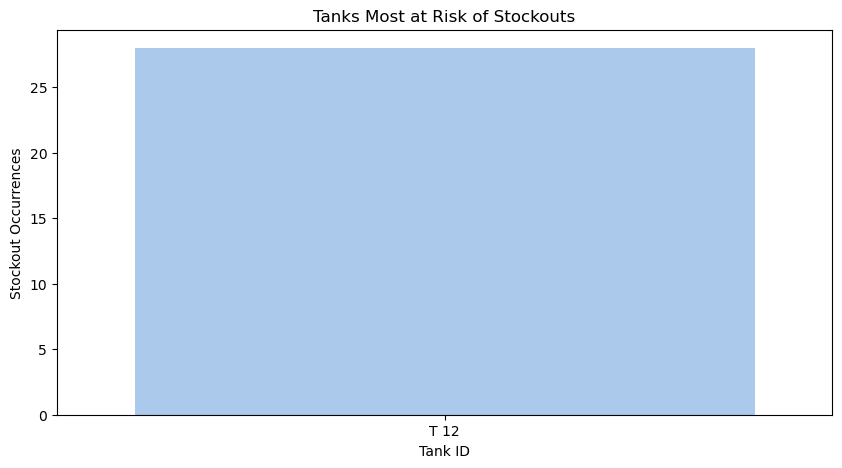

/var/folders/jx/9_tlttmd2w7b3rzppx7v1q5c0000gn/T/ipykernel_11055/2118755871.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=effective_inventory.head(10), x='Tank ID', y='Effective_Inventory_Count', palette='pastel')


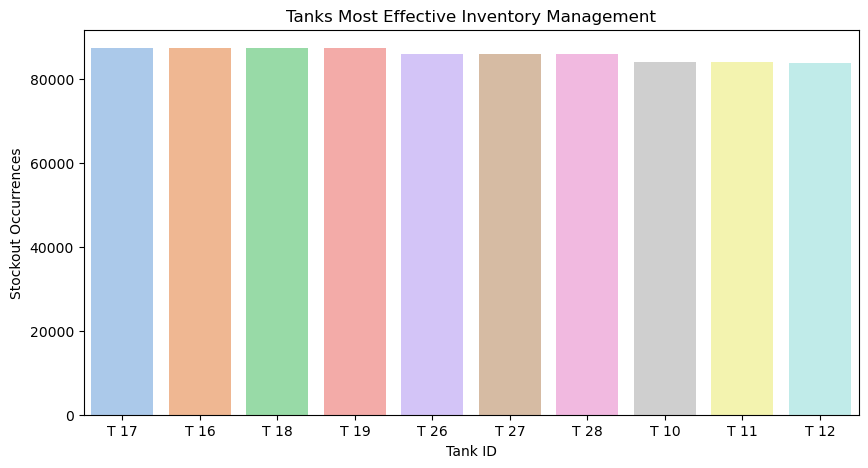

In [5]:
# Convert Time_Stamp to datetime
Fuel_all_q1=Fuel_all
Fuel_all_q1['Time_Stamp'] = pd.to_datetime(Fuel_all_q1['Time_Stamp'], errors='coerce')
Fuel_all_q1 = Fuel_all_q1.sort_values(['Tank ID', 'Time_Stamp'])

# Plot fuel level trends for a few sample tanks
sample_tanks = Fuel_all_q1['Tank ID'].unique()
plt.figure(figsize=(12, 6))
for tank in sample_tanks:
    tank_data = Fuel_all_q1[Fuel_all_q1['Tank ID'] == tank]
    plt.plot(tank_data['Time_Stamp'], tank_data['Fuel_Level'], label=f'Tank {tank}')
plt.title('Fuel Level Trends (Sample Tanks)')
plt.xlabel('Date')
plt.ylabel('Fuel Level (Liters)')
plt.legend()
plt.grid(True)
plt.show()

# Identify potential stockouts( define stockout as <10% of the tank's capacity)
Fuel_merged_q1 = Fuel_all_q1.merge(Tanks[['Tank ID', 'Tank Capacity', 'Station_Location']], on='Tank ID', how='left')
Fuel_merged_q1['Stockout_Risk'] = Fuel_merged_q1['Fuel_Level'] / Fuel_merged_q1['Tank Capacity'] < 0.1

# Count how many times each tank reached stockout risk
effective_inventory= Fuel_merged_q1[Fuel_merged_q1['Stockout_Risk'] ==False].groupby('Tank ID')['Stockout_Risk'].count().reset_index()
effective_inventory.columns= ['Tank ID', 'Effective_Inventory_Count']
effective_inventory = effective_inventory.sort_values('Effective_Inventory_Count', ascending=False)
stockout= Fuel_merged_q1[Fuel_merged_q1['Stockout_Risk'] ==True].groupby('Tank ID')['Stockout_Risk'].count().reset_index()
stockout.columns = ['Tank ID', 'Stockout_Risk_Count']
stockout = stockout.sort_values('Stockout_Risk_Count', ascending=False)

# Visualization: Tanks with highest stockout frequency
plt.figure(figsize=(10,5))
sns.barplot(data=stockout.head(10), x='Tank ID', y='Stockout_Risk_Count', palette='pastel')
plt.title('Tanks Most at Risk of Stockouts')
plt.xlabel('Tank ID')
plt.ylabel('Stockout Occurrences')
plt.show()
# Tanks with highest effective inventory management
plt.figure(figsize=(10,5))
sns.barplot(data=effective_inventory.head(10), x='Tank ID', y='Effective_Inventory_Count', palette='pastel')
plt.title('Tanks Most Effective Inventory Management')
plt.xlabel('Tank ID')
plt.ylabel('Stockout Occurrences')
plt.show()

### 1.3 Quantify Current Performance
We analyzed purchasing patterns in the Invoices dataset.

   Station_Location  Total_Purchases    Total_Cost  Total_Savings  Avg_Price  \
0                 1     1.573867e+07  1.819895e+07   190587.37552   1.223942   
1                 2     6.283414e+06  7.055550e+06    10296.32160   1.180982   
2                 3     8.553338e+05  9.403072e+05     1955.05056   1.122546   
5                 6     4.413100e+05  4.857741e+05     1461.89504   1.158511   
7                 8     2.837933e+05  3.200829e+05     1335.39648   1.235332   
3                 4     3.211086e+06  3.698334e+06      343.36672   1.221601   
4                 5     2.158447e+06  2.482370e+06        0.00000   1.223276   
6                 7     1.046451e+05  1.173553e+05        0.00000   1.231476   

   Savings_%  
0   1.036390  
1   0.145720  
2   0.207485  
5   0.300038  
7   0.415470  
3   0.009283  
4   0.000000  
6   0.000000  


/var/folders/jx/9_tlttmd2w7b3rzppx7v1q5c0000gn/T/ipykernel_11055/2759843943.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Station_Location', y='Total_Savings', palette='coolwarm')


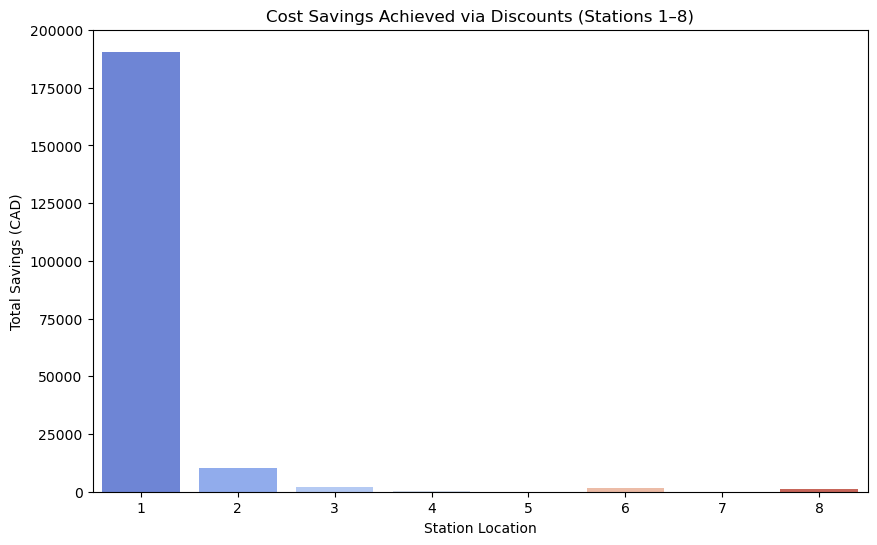

In [6]:
# Compute price per liter for each invoice
Invoices_q1=Invoices
Invoices_q1['Price_per_Liter'] = Invoices_q1['Gross Purchase Cost'] / Invoices_q1['Amount Purchased']

# Add discount column based on quantity
def discount_rate(qty):
    if qty < 15000:
        return 0
    elif qty < 25000:
        return 0.02
    elif qty < 40000:
        return 0.03
    else:
        return 0.04

Invoices_q1['Discount_per_Liter'] = Invoices_q1['Amount Purchased'].apply(discount_rate)
Invoices_q1['Discount_Savings'] = Invoices_q1['Amount Purchased'] * Invoices_q1['Discount_per_Liter']

# Summarize purchasing and savings
stations_1_8 = Invoices_q1[Invoices_q1['Station_Location'].isin(range(1,9))]
summary = stations_1_8.groupby('Station_Location').agg(
    Total_Purchases=('Amount Purchased', 'sum'),
    Total_Cost=('Gross Purchase Cost', 'sum'),
    Total_Savings=('Discount_Savings', 'sum'),
    Avg_Price=('Price_per_Liter', 'mean')
).reset_index()

summary['Savings_%'] = 100 * summary['Total_Savings'] / (summary['Total_Cost'] + summary['Total_Savings'])
summary = summary.sort_values('Total_Savings', ascending=False)
print(summary)

# Visualization of total savings by station
plt.figure(figsize=(10,6))
sns.barplot(data=summary, x='Station_Location', y='Total_Savings', palette='coolwarm')
plt.title('Cost Savings Achieved via Discounts (Stations 1–8)')
plt.xlabel('Station Location')
plt.ylabel('Total Savings (CAD)')
plt.show()

## Question 2 Recommend Improved Ordering Strategies
### 2.1 Determine the highest applicable discount rate

We calculated the `Total Tank Capacity`(the sum of `Tank Number`× `Tank Capacity`) for each station and fuel type, and determined the highest applicable discount rate based on that capacity.

In [7]:
Tanks_q2=Tanks.set_index(['Station_Location','Type']).sort_index(level=['Station_Location','Type'])
# calculate ['Total Tank Capacity'] for each location and fuel type
Tanks_q2['T_Capacity']=Tanks_q2['Tank Number']*Tanks_q2['Tank Capacity']
Tanks_q2['Total Tank Capacity']=Tanks_q2.groupby(['Station_Location','Type'])['T_Capacity'].sum()
# calculate ['Highest Applicable Discount Rate($)'] for each location and fuel type
Tanks_q2['Highest Applicable Discount Rate($)']= Tanks_q2['Total Tank Capacity'].apply(
    lambda x: 0.04 if x > 40000
                else 0.03 if 25000 < x <= 40000
                else 0.02 if 15000 < x <= 25000
                else 0)
# drop unnecessary columns & rows
Tanks_q2.reset_index(inplace=True)
Tanks_q2=Tanks_q2.drop(['Tank Number','Tank Capacity','T_Capacity'],axis=1)
Tanks_q2.drop_duplicates(inplace=True)
Tanks_q2.head(5)

,Station_Location,Type,Tank ID,Total Tank Capacity,Highest Applicable Discount Rate($)
0,1,D,T 12,360000,0.04
1,1,D,T 15,360000,0.04
2,1,G,T 10,480000,0.04
3,1,G,T 11,480000,0.04
4,1,G,T 13,480000,0.04


### 2.2 Calculate the 7-day inventory threshold

Calculate the average daily fuel consumption by computing the daily decrease(`Fuel_Level_Diff`=the difference between the previous row and the next row) in Fuel_Level for each `Tank ID` in Fuel.csv.

In [8]:
Fuel_all_q2=Fuel_all
Fuel_all_q2['Time_Stamp'] = pd.to_datetime(Fuel_all_q2['Time_Stamp'], errors='coerce')
Fuel_all_q2 = Fuel_all_q2.sort_values(by=['Tank ID','Time_Stamp'])
Fuel_all_q2=Fuel_all_q2.set_index('Tank ID')
# only calculate the portions where the fuel level decreases (consumption)
Fuel_all_q2['Fuel_Level_Diff'] = (-Fuel_all_q2.groupby('Tank ID')['Fuel_Level'].diff().round(0).fillna(0).astype(int)).clip(lower=0)
# transform ['Time_Stamp'] to datetime and split ['Date']
Fuel_all_q2['Date'] = Fuel_all_q2['Time_Stamp'].dt.date
Fuel_all_q2.reset_index(inplace=True)
Fuel_all_q2.head(5)

,Tank ID,Fuel_Level,Time_Stamp,Fuel_Level_Diff,Date
0,T 10,25700.0,2017-01-01 00:09:00,0,2017-01-01
1,T 10,25666.0,2017-01-01 00:24:00,34,2017-01-01
2,T 10,25624.0,2017-01-01 00:39:00,42,2017-01-01
3,T 10,25560.0,2017-01-01 00:54:00,64,2017-01-01
4,T 10,25560.0,2017-01-01 01:09:00,0,2017-01-01


Merge sections 2.1 and 2.2, then aggregate `Average_Daily_Consumption` for each location and fuel type based on `Fuel_Level_Diff`, and subsequently calculate the 7-day inventory threshold(`7day_Threshold`=`Average_Daily_Consumption`*7).

In [9]:
# merge 2.1 & 2.2
Fuel_all_Tanks_q2=Tanks_q2[['Station_Location','Type','Tank ID']].merge(Fuel_all_q2[['Tank ID','Date','Fuel_Level_Diff']],on=['Tank ID'],how='outer').sort_values(by=['Date','Tank ID'])
Fuel_all_Tanks_q2=Fuel_all_Tanks_q2.set_index(['Station_Location','Type','Tank ID','Date']).sort_index(level=[0,1,2,3])
# calculate ['Daily_Consumption']
Fuel_all_Tanks_q2['Daily_Consumption'] = Fuel_all_Tanks_q2.groupby(['Station_Location','Type','Tank ID','Date'])['Fuel_Level_Diff'].sum()
# drop unnecessary columns & rows
Fuel_all_Tanks_q2.reset_index(['Tank ID','Date'],inplace=True)
Fuel_all_Tanks_q2=Fuel_all_Tanks_q2.drop(['Fuel_Level_Diff','Tank ID','Date'],axis=1)
Fuel_all_Tanks_q2.drop_duplicates(inplace=True)
# calculate ['Average_Daily_Consumption']
Fuel_all_Tanks_q2['Average_Daily_Consumption']=Fuel_all_Tanks_q2.groupby(['Station_Location','Type'])['Daily_Consumption'].mean().round(0)
# drop unnecessary columns & rows
Fuel_all_Tanks_q2=Fuel_all_Tanks_q2.drop(['Daily_Consumption'],axis=1)
Fuel_all_Tanks_q2.drop_duplicates(inplace=True)
# calculate ['7day_Threshold']
Fuel_all_Tanks_q2['7day_Threshold'] = Fuel_all_Tanks_q2['Average_Daily_Consumption'] * 7
Fuel_all_Tanks_q2.head(5)

Average_Daily_Consumption  7day_Threshold
Station_Location Type                                           
1                D                        3640.0         25480.0
                 G                        4169.0         29183.0
2                D                        2020.0         14140.0
                 G                        1627.0         11389.0
3                D                         657.0          4599.0

### 2.3 Compute potential savings

We computed the `Optimized_Order_Quantity(L)`(the order quantity that achieves the maximum discount, while ensuring it exceeds the 7-day threshold) and the `Potential Savings($)`(=`Optimized_Order_Quantity(L)`× `Highest Applicable Discount Rate($)`) for each station and fuel type. \
\
**The optimized inventory policy** sets each order quantity to maximize potential cost savings while ensuring it`>= 7day_Threshold` & `<= Total Tank Capacity` limit.


In [10]:
# merge 2.1 & 2.2
Savings_q2=Fuel_all_Tanks_q2.merge(Tanks_q2,on=['Station_Location','Type'],how='outer').set_index(['Station_Location','Type']).sort_index(level=[0,1])
# drop unnecessary columns & rows
Savings_q2=Savings_q2.drop(['Tank ID'],axis=1)
Savings_q2.drop_duplicates(inplace=True)
# calculate maximum ['Optimized_Order_Quantity(L)'] to get the maximum discount
def order_quantity(a):
    if a==0.04:
        return 45000
    elif a==0.03:
        return 40000
    elif a==0.02:
        return 25000
    else:
        return 15000
Savings_q2['Optimized_Order_Quantity(L)']=Savings_q2['Highest Applicable Discount Rate($)'].apply(order_quantity)
# calculate Potential Savings($)
Savings_q2['Potential Savings($)']=Savings_q2['Optimized_Order_Quantity(L)']*Savings_q2['Highest Applicable Discount Rate($)']
Savings_q2

Average_Daily_Consumption  7day_Threshold  \
Station_Location Type                                              
1                D                        3640.0         25480.0   
                 G                        4169.0         29183.0   
2                D                        2020.0         14140.0   
                 G                        1627.0         11389.0   
3                D                         657.0          4599.0   
                 G                        1022.0          7154.0   
4                D                        3347.0         23429.0   
                 G                        2746.0         19222.0   
5                D                        1608.0         11256.0   
                 G                        2409.0         16863.0   
6                D                         183.0          1281.0   
                 G                         519.0          3633.0   
7                D                          75.0           525.0   
                 G                         220.0          1540.0   
8                D                         320.0          2240.0   
                 G                         861.0          6027.0   

                       Total Tank Capacity  \
Station_Location Type                        
1                D                  360000   
                 G                  480000   
2                D                  360000   
                 G                  190000   
3                D                   60000   
                 G                   30000   
4                D                   80000   
                 G                   40000   
5                D                   25000   
                 G                   50000   
6                D                   90000   
                 G                   90000   
7                D                   10000   
                 G                    5000   
8                D                   40000   
                 G                   80000   

                       Highest Applicable Discount Rate($)  \
Station_Location Type                                        
1                D                                    0.04   
                 G                                    0.04   
2                D                                    0.04   
                 G                                    0.04   
3                D                                    0.04   
                 G                                    0.03   
4                D                                    0.04   
                 G                                    0.03   
5                D                                    0.02   
                 G                                    0.04   
6                D                                    0.04   
                 G                                    0.04   
7                D                                    0.00   
                 G                                    0.00   
8                D                                    0.03   
                 G                                    0.04   

                       Optimized_Order_Quantity(L)  Potential Savings($)  
Station_Location Type                                                     
1                D                           45000                1800.0  
                 G                           45000                1800.0  
2                D                           45000                1800.0  
                 G                           45000                1800.0  
3                D                           45000                1800.0  
                 G                           40000                1200.0  
4                D                           45000                1800.0  
                 G                           40000                1200.0  
5                D                           25000                 500.0  
                 G         

## Question 3 Identify the Best Day for Fuel Orders

### 3.1 Examine the distribution of price-per-liter rates by day of the week

The fuel prices before discount were extracted, and a new column indicating the **day of the week** was added. The dataset was then divided into gasoline and diesel for **separate analysis**. Finally, the price per liter distribution was examined across days of the week to identify pricing patterns.

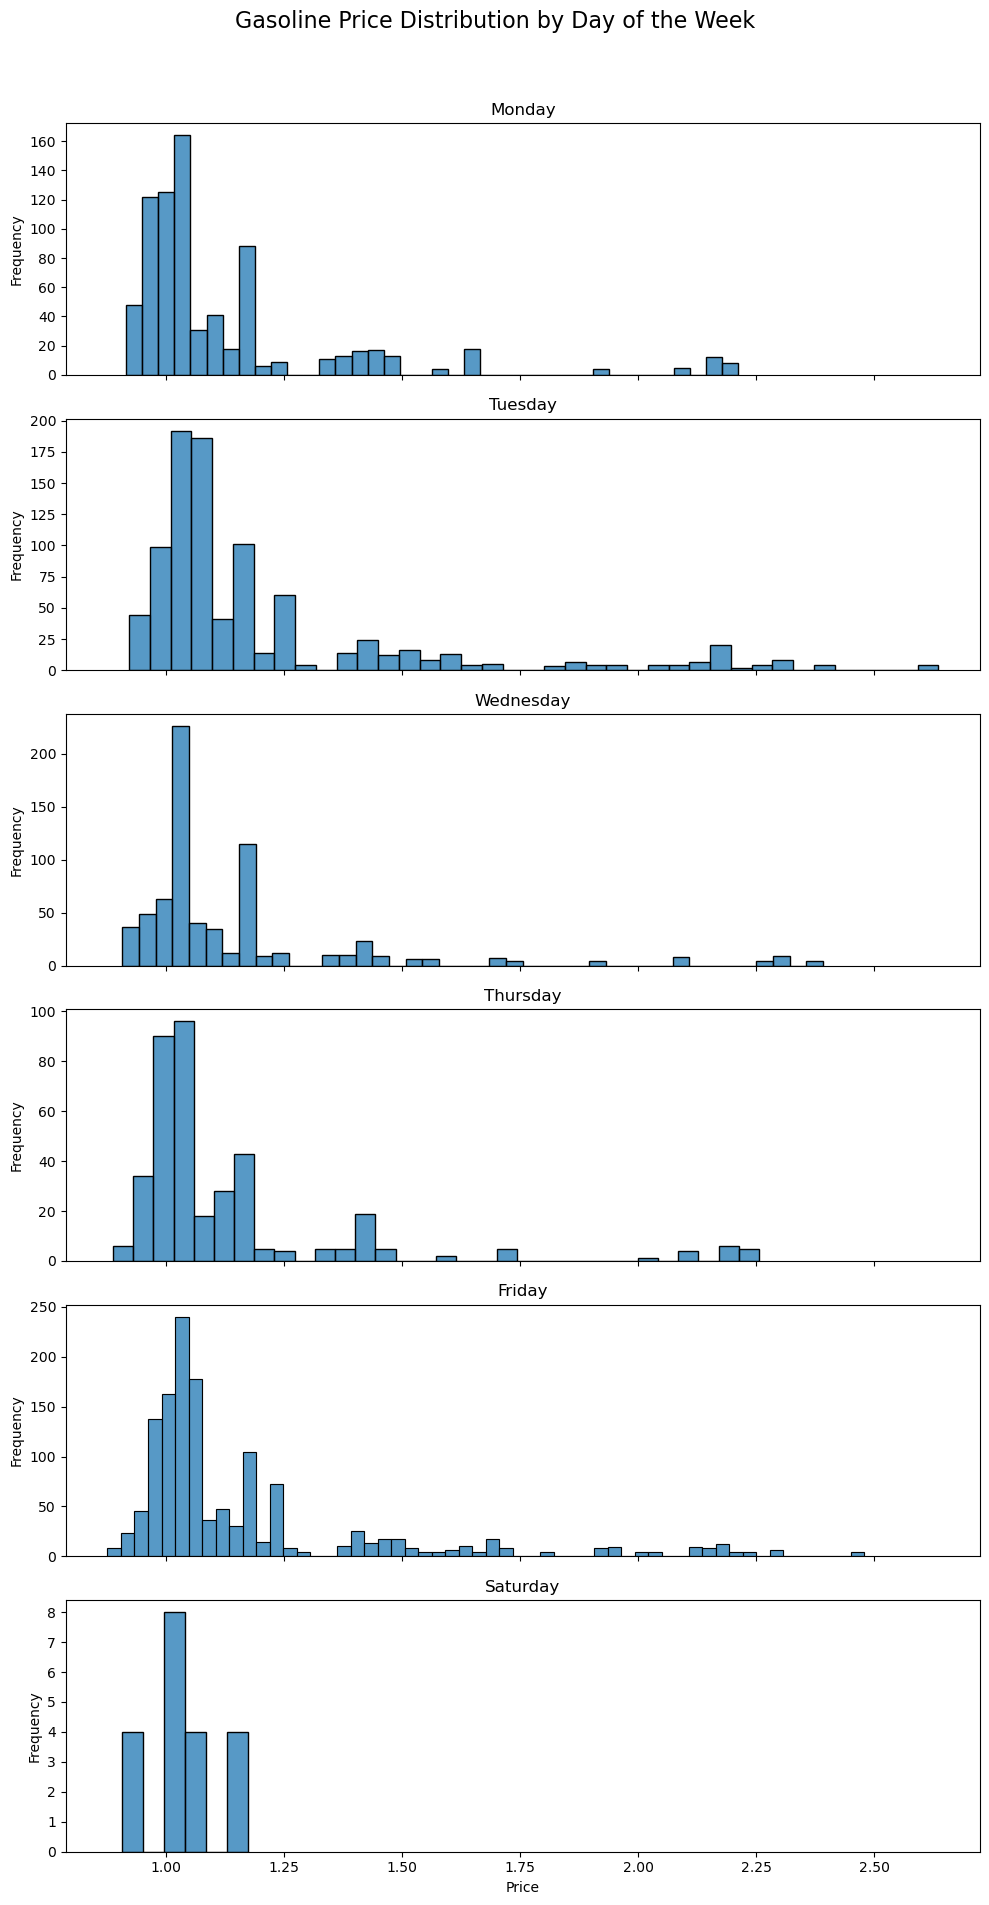

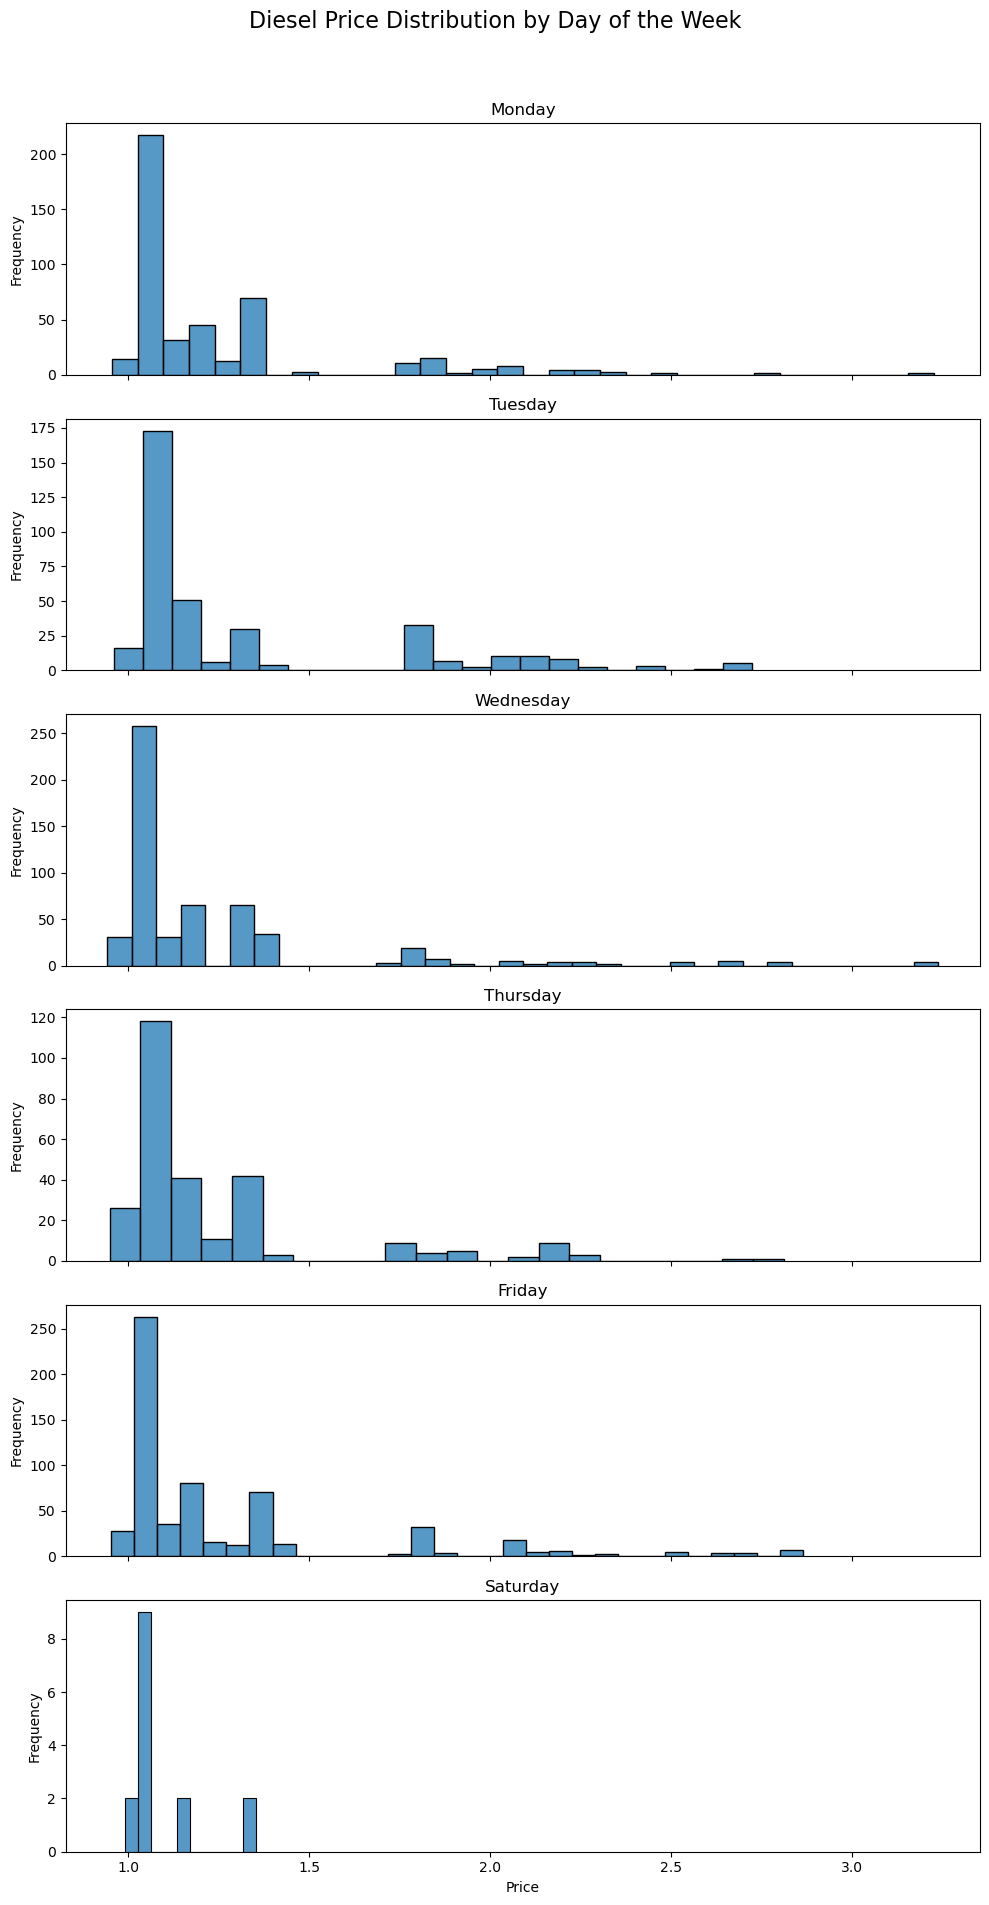

In [11]:
Tanks_Invoices_Locations_q3=Tanks_Invoices_Locations
Tanks_Invoices_Locations_q3['Fuel Price']=Tanks_Invoices_Locations_q3['Gross Purchase Cost']/Tanks_Invoices_Locations_q3['Amount Purchased']
Tanks_Invoices_Locations_q3['Invoice Date'] = pd.to_datetime(Tanks_Invoices_Locations_q3['Invoice Date'])
# Create the new 'Day' column by extracting the day name
Tanks_Invoices_Locations_q3['Day'] = Tanks_Invoices_Locations_q3['Invoice Date'].dt.day_name()
Tanks_Invoices_Locations_q3.head()
# Subset for Diesel using .xs()
diesel_df = Tanks_Invoices_Locations_q3.xs('D', level='Type')
# Subset for Gas using .xs()
gas_df = Tanks_Invoices_Locations_q3.xs('G', level='Type')
# Define function for plotting fuel price distribution by weekday
def plot_price_distribution(df, fuel_type):
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days = [day for day in days_order if day in df['Day'].unique()]

    fig, axes = plt.subplots(len(days), 1, figsize=(10, 20), sharex=True)
    fig.suptitle(f'{fuel_type} Price Distribution by Day of the Week', fontsize=16)

    for i, day in enumerate(days):
        sns.histplot(df[df['Day'] == day]['Fuel Price'], ax=axes[i], kde=False)
        axes[i].set_title(day)
        axes[i].set_xlabel('Price')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Plot for both fuel types
plot_price_distribution(gas_df, "Gasoline")
plot_price_distribution(diesel_df, "Diesel")


### 3.2 Identify the day with the lowest historical rates

The analysis of average diesel prices by day shows that **Saturday** has the lowest rates. However, both the histogram and data count indicate that Saturday has very few observations (fewer than 20), making it unreliable for business estimation. Therefore, a new comparison day was selected.

In [12]:
historical_rates = pd.DataFrame({
    'Diesel': diesel_df.groupby('Day')['Fuel Price'].mean(),
     'Gas': gas_df.groupby('Day')['Fuel Price'].mean()}).sort_values(by=['Diesel','Gas'],ascending=True)
historical_rates
# Saturday has the lowest rates, and Thusday for Diesel, Monday for Gas is smallest apart from Saturday.

,Diesel,Gas
Day,,
Saturday,1.098307,1.034955
Thursday,1.243545,1.134596
Wednesday,1.252391,1.146243
Monday,1.255257,1.133494
Friday,1.284317,1.169131
Tuesday,1.318902,1.205227


In [13]:
day_counts = pd.DataFrame({
    'Diesel': diesel_df['Day'].value_counts(),
    'Gas': gas_df['Day'].value_counts()}).sort_values(by=['Diesel','Gas'],ascending=True)
day_counts
# But Saturday prices have less values than other days for both kinds of fuel，

,Diesel,Gas
Day,,
Saturday,15,20
Thursday,275,381
Tuesday,361,912
Monday,452,773
Wednesday,549,701
Friday,614,1330


Since Thursday and Monday shows the lowest average price after excluding Saturday, which has too few data points, a t-test using Thursday’s mean, standard deviation, and sample size is needed to check if the difference is statistically significant. We conducted t-tests to see whether **diesel prices on Thursday** and **gas prices on Monday** were truly lower than the overall average or just by chance. Results show both days have significantly lower prices.

In [14]:
# Calculate the variance of all the Diesel price
diesel_df['Fuel Price'].std()
0.37732466738570386*0.37732466738570386
# Calculate the variance of Diesel price on Thursday
diesel_df.loc[diesel_df['Day'] == 'Thursday', 'Fuel Price'].std()
0.3257007045449677*0.3257007045449677

# Calculate the variance of all the gas price
gas_df['Fuel Price'].std()
0.2854366346500981*0.2854366346500981
# Calculate the variance of gas price on Monday
gas_df.loc[gas_df['Day'] == 'Monday', 'Fuel Price'].std()
0.252877584608149*0.252877584608149

# Sample 1 Statistics
mean1 = 1.243545
nobs1 = 275
std1 = 0.10608094894108834

# Sample 2 Statistics
mean2 = 1.2701156907452578
nobs2 = 2266
std2 = 0.14237390461773206

# Perform the two-sample t-test from statistics
# We use 'ttest_ind_from_stats' for this purpose
# 'equal_var=False' specifies a Welch's t-test, which doesn't assume equal variance
# 'alternative='less'' sets the alternative hypothesis to mean1 < mean2
t_statistic, p_value = stats.ttest_ind_from_stats(
    mean1=mean1,
    std1=std1,
    nobs1=nobs1,
    mean2=mean2,
    std2=std2,
    nobs2=nobs2,
    equal_var=False,
    alternative='less'
)
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Test for gas
import scipy.stats as stats

# Sample 1 Statistics
mean1 = 1.133494
nobs1 = 773
std1 = 0.06394707279725156

# Sample 2 Statistics
mean2 = 1.1626908893778092
nobs2 = 4117
std2 = 0.08147407240037359

# Perform the two-sample t-test from statistics
# We use 'ttest_ind_from_stats' for this purpose
# 'equal_var=False' specifies a Welch's t-test, which doesn't assume equal variance
# 'alternative='less'' sets the alternative hypothesis to mean1 < mean2
t_statistic, p_value = stats.ttest_ind_from_stats(
    mean1=mean1,
    std1=std1,
    nobs1=nobs1,
    mean2=mean2,
    std2=std2,
    nobs2=nobs2,
    equal_var=False,
    alternative='less'
)
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -3.762707288142334
P-value: 9.64650238979465e-05
T-statistic: -11.113117003039557
P-value: 9.100919788870966e-28


### 3.3 Calculate the savings if all the purchase of gas is made on Thursday

In [19]:
diesel_df['Invoice Date']= pd.to_datetime(diesel_df['Invoice Date'])
days_to_thursday = (3 - diesel_df['Invoice Date'].dt.weekday + 7) % 7
offset = pd.to_timedelta(days_to_thursday, unit='d')
upcoming_thursday = diesel_df['Invoice Date'] + offset

#Determine the nearest Thursday
diesel_df['Nearest_Thursday'] = np.where(
    offset.dt.days > 3,
    upcoming_thursday - pd.Timedelta(days=7),
    upcoming_thursday)

# Attibute the nearest Thursday price to all rows
diesel_df['Invoice Date'] = pd.to_datetime(diesel_df['Invoice Date'])
diesel_df['Nearest_Thursday'] = pd.to_datetime(diesel_df['Nearest_Thursday'])
thursdays_df = diesel_df[diesel_df['Invoice Date'] == diesel_df['Nearest_Thursday']]
# We drop duplicates to ensure each Thursday has only one price.
thursday_price_map = thursdays_df.drop_duplicates(subset=['Nearest_Thursday']).set_index('Nearest_Thursday')['Fuel Price']
# Use the map to create the new 'Mon Price' column in the original DataFrame
diesel_df['Thurs Price'] = diesel_df['Nearest_Thursday'].map(thursday_price_map)
diesel_df.head()
# Create a column that calculate the money saved
# Calculate the Money Saved column
diesel_df['Money Saved'] = (diesel_df['Fuel Price'] - diesel_df['Thurs Price']) * diesel_df['Amount Purchased']
diesel_df.loc[diesel_df['Money Saved'] < 0, 'Money Saved'] = 0
diesel_df.head(2)

/var/folders/jx/9_tlttmd2w7b3rzppx7v1q5c0000gn/T/ipykernel_11055/109684989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diesel_df['Invoice Date']= pd.to_datetime(diesel_df['Invoice Date'])
/var/folders/jx/9_tlttmd2w7b3rzppx7v1q5c0000gn/T/ipykernel_11055/109684989.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diesel_df['Nearest_Thursday'] = np.where(
/var/folders/jx/9_tlttmd2w7b3rzppx7v1q5c0000gn/T/ipykernel_11055/109684989.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,Tank ID,Tank Number,Tank Capacity,Invoice Date,Invoice ID,Gross Purchase Cost,Amount Purchased,Gas Station Name,Gas Station Address,Gas Station Latitude,Gas Station Longitude,Fuel Price,Day,Nearest_Thursday,Thurs Price,Money Saved
Station_Location,,,,,,,,,,,,,,,,
1,T 12,3,40000,2017-01-02,10001.0,12491.85300,9338.736,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",43.23467,-79.83651,1.337639,Monday,2017-01-05,1.337639,0.000000
1,T 12,3,40000,2017-01-03,10006.0,5670.54418,4239.216,EastMount,"386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada",43.23467,-79.83651,1.337640,Tuesday,2017-01-05,1.337639,0.005565


## Question 4 Evaluate the Feasibility of Adding Tanks

### 4.1 Assume the cost of adding a new tank and the average inflation rate
Assume that the cost of adding a new tank increases with inflation, using the average CPI over the past five years (official, reliable, and easily accessible). Tank costs are based on market prices from the CommTank website, providing actual estimates for tanks of different capacities and materials.


In [20]:
#Assuming based on the average inflation rate over the past 5 years
#reference：https://www.bls.gov/charts/consumer-price-index/consumer-price-index-by-category-line-chart.htm
CPI_2019_Dec=0.023
CPI_2024_Dec=0.029
inflation_rate = ((CPI_2024_Dec / CPI_2019_Dec) ** (1/5) - 1)
print(inflation_rate)

0.04745176373283


In [21]:
#Assumed additional cost for each type of tank
#reference：https://www.commtank.com/ufaqs/how-much-does-a-gas-station-fuel-tank-cost
Cost=pd.DataFrame({'Tank Capacity':[70000,40000,30000,25000,5000],
      'Tank Cost':[40000,25000,15000,12500,3000],
      'Installation Cost':[7000,4000,3000,2500,500]})
Cost['Total Cost']=Cost['Tank Cost']+Cost['Installation Cost']
Cost

,Tank Capacity,Tank Cost,Installation Cost,Total Cost
0,70000,40000,7000,47000
1,40000,25000,4000,29000
2,30000,15000,3000,18000
3,25000,12500,2500,15000
4,5000,3000,500,3500


### 4.2 Estimate the cost-benefit of increased capacity over a 5-year period.
Since we are evaluating the cost–benefit ratio of increasing capacity over the next five years, we quantify the problem by examining whether the difference between the profit of the added tank and the cost of the added tank yields a reasonable cost–benefit ratio.

$$
\text{Cost–Benefit Ratio} = \frac{\Delta \text{Profit ()}}{\Delta \text{Cost ()}}
$$


In [22]:
#Calculate the turnover rate for each type of tank
#Calculate the annual purchase volume for each tank type at each location
Q4 = Tanks_Invoices_Locations.loc[:, ['Tank Capacity', 'Invoice Date', 'Amount Purchased']]
Q4.reset_index(inplace=True)
Q4['Invoice Date'] = pd.to_datetime(Q4['Invoice Date'])
Q4['Year'] = Q4['Invoice Date'].dt.year
Q4.drop(['Type','Invoice Date'],axis=1,inplace=True)
Q4.set_index(['Station_Location', 'Tank Capacity','Year'],inplace=True)
Q4['Annual Purchased']= Q4.groupby(['Station_Location', 'Tank Capacity','Year'])['Amount Purchased'].sum()
Q4.reset_index(inplace=True)
Q4.drop(['Year','Amount Purchased'],axis=1,inplace=True)
Q4.drop_duplicates(inplace=True)
Q4.set_index(['Station_Location', 'Tank Capacity'],inplace=True)
Q4['Annual Average Purchased']= Q4.groupby(['Station_Location', 'Tank Capacity'])['Annual Purchased'].mean()
Q4.drop(['Annual Purchased'],axis=1,inplace=True)
Q4.reset_index(inplace=True)

#Calculate the turnover for each tank type
Q4['Turnover']=round(Q4['Annual Average Purchased']/Q4['Tank Capacity'],0)
Q4.drop_duplicates(subset=['Station_Location','Tank Capacity'], inplace=True)
Q4

,Station_Location,Tank Capacity,Annual Average Purchased,Turnover
0,1,40000,1.773659e+07,443.0
3,2,40000,2.094471e+06,52.0
6,2,70000,2.094471e+06,30.0
9,3,30000,2.851113e+05,10.0
12,4,40000,1.070362e+06,27.0
15,5,25000,7.194823e+05,29.0
18,6,30000,2.759967e+05,9.0
21,7,5000,3.488170e+04,7.0
24,8,40000,9.459778e+04,2.0


In [23]:
Q4=Q4.merge(Cost[['Total Cost','Tank Capacity']],on='Tank Capacity',how='left')
# Since between 2014 and 2019, annual gross rack-to-retail margins averaged about 22–24 cents per gallon, we assume a profit of 6 cents per liter.
#Reference：https://www.opis.com/blog/retail-gasoline-price-margins
Q4['Profit/Liter']=0.06
# Calculate the profit for the next 5 years
Q4['Annual Profit']=Q4['Profit/Liter']*Q4['Tank Capacity']*Q4['Turnover']
years = [1, 2, 3, 4, 5]
for i in years:
    Q4[f'Profit_Y{i}'] = Q4['Annual Profit'] * ((1 + inflation_rate) ** i)
Q4['Total_5yr_Profit'] = Q4[[f'Profit_Y{i}' for i in years]].sum(axis=1)
Q4.drop(Q4[[f'Profit_Y{i}' for i in years]],axis=1,inplace=True)
# Calculate Cost_Benefit_Ratio
Q4['Cost_Benefit_Ratio']=Q4['Total_5yr_Profit']/Q4['Total Cost']
Q4

,Station_Location,Tank Capacity,Annual Average Purchased,Turnover,Total Cost,Profit/Liter,Annual Profit,Total_5yr_Profit,Cost_Benefit_Ratio
0,1,40000,1.773659e+07,443.0,29000,0.06,1063200.0,6.122377e+06,211.116442
1,2,40000,2.094471e+06,52.0,29000,0.06,124800.0,7.186537e+05,24.781162
2,2,70000,2.094471e+06,30.0,47000,0.06,126000.0,7.255638e+05,15.437529
3,3,30000,2.851113e+05,10.0,18000,0.06,18000.0,1.036520e+05,5.758443
4,4,40000,1.070362e+06,27.0,29000,0.06,64800.0,3.731471e+05,12.867142
5,5,25000,7.194823e+05,29.0,15000,0.06,43500.0,2.504923e+05,16.699485
6,6,30000,2.759967e+05,9.0,18000,0.06,16200.0,9.328678e+04,5.182599
7,7,5000,3.488170e+04,7.0,3500,0.06,2100.0,1.209273e+04,3.455066
8,8,40000,9.459778e+04,2.0,29000,0.06,4800.0,2.764053e+04,0.953122


### 4.3 Identify locations that would benefit most from additional tanks.

Based on the visualized Cost–Benefit Ratio column, we can easily conclude that **Station 1** would benefit most from additional tanks, as it has the highest Cost–Benefit Ratio.


/var/folders/jx/9_tlttmd2w7b3rzppx7v1q5c0000gn/T/ipykernel_11055/2009290246.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  Q4_plot=sns.barplot(x='Station_Location', y='Cost_Benefit_Ratio', data=Q4[:10], palette='RdPu')


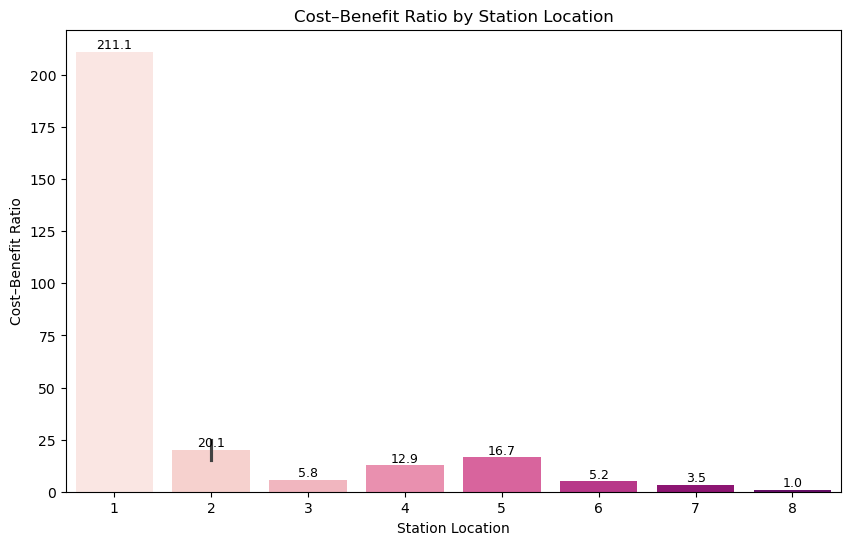

In [24]:
Q4=Q4.sort_values(by=['Cost_Benefit_Ratio'],ascending=False)

#Visualize the Cost_Benefit_Ratio column
plt.figure(figsize=(10,6))
Q4_plot=sns.barplot(x='Station_Location', y='Cost_Benefit_Ratio', data=Q4[:10], palette='RdPu')
plt.title('Cost–Benefit Ratio by Station Location')
plt.xlabel('Station Location')
plt.ylabel('Cost–Benefit Ratio')

# Display the values on top of the bars
for p in Q4_plot.patches:
    height = p.get_height()
    Q4_plot.annotate(f'{height:.1f}',
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=9)

plt.show()